In [22]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense, BatchNormalization, LeakyReLU, Layer, Input
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
import keras_tuner as kt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Attention
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [23]:
# Define the attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.activations.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.keras.activations.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# Define the model
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(hp.Int('window_size', min_value=3, max_value=10, step=1, default=7), X_train.shape[2])))

    filter_size = hp.Int('filters', min_value=32, max_value=128, step=32, default=32)
    kernel_size = hp.Int('kernel_size', min_value=2, max_value=5, step=1, default=4)
    activation_function = hp.Choice('activation_function', values=['relu', 'leaky_relu'], default='leaky_relu')
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32, default=32)
    dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1, default=0.4)
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'], default='adam')
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='LOG', default=0.001)
    batch_size = hp.Int('batch_size', min_value=16, max_value=256, step=16, default=64)

    model.add(Conv1D(
        filters=filter_size,
        kernel_size=kernel_size,
        padding='same',
        activation=LeakyReLU(alpha=0.1) if activation_function == 'leaky_relu' else 'relu',
        kernel_regularizer=l2(hp.Float('l2', 1e-5, 1e-2, sampling='LOG'))
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
    model.add(AttentionLayer())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer_choice, loss='mean_squared_error')
    return model

In [24]:
# Load the CSV file into a DataFrame
df = pd.read_csv("C:/Users/T sreenivasulu/Desktop/DATASETS/interpolated_df1.csv")
# Convert 'Date' column to datetime with dayfirst=True
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
# Set 'date' column as index
df.set_index('Date', inplace=True)


In [25]:
# Select the target variable (PM2.5)
target = df['PM2.5 ']

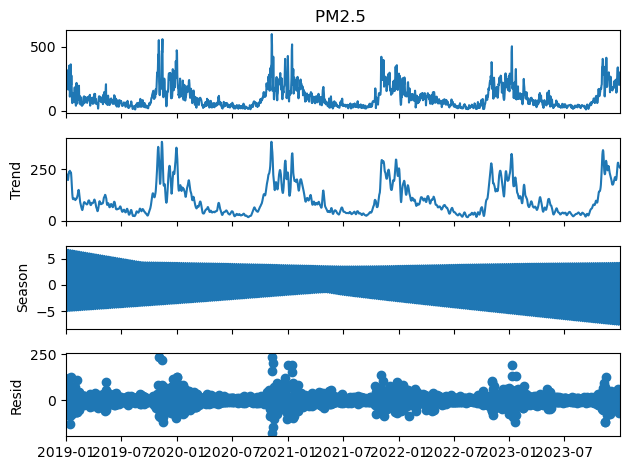

In [26]:
from statsmodels.tsa.seasonal import STL
# Decompose the time series
stl = STL(target, seasonal=365)
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid

import matplotlib.pyplot as plt
# Plot the decomposition
result.plot()
plt.show()

# Combine the components into a DataFrame
components_df = pd.DataFrame({
    'seasonal': seasonal,
    'trend': trend,
    'resid': resid
})

In [27]:
# Select additional features
features = df[['PM10', 'NO', 'NO2 ', 'NOx ', 'CO', 'Benzene', 'AT',  'WS', 'SR', 'BP']]

In [28]:
from sklearn.preprocessing import MinMaxScaler
# Scale the components and features
scaler_components = MinMaxScaler()
scaled_components = scaler_components.fit_transform(components_df)
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(features)

# Separate scaler for the target variable
scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Combine scaled components and features (without target scaling)
combined_scaled_data = np.concatenate([scaled_components, scaled_features], axis=1)

# Convert back to DataFrame
combined_scaled_df = pd.DataFrame(combined_scaled_data, index=components_df.index, columns=list(components_df.columns) + list(features.columns))


In [29]:
# Add lagged variables
def add_lagged_variables(df, target_column, lags=7):
    for lag in range(1, lags + 1):
        df[f'{target_column}_lag{lag}'] = df[target_column].shift(lag)
    return df

In [30]:
# Add lagged PM2.5 variables
combined_scaled_df = add_lagged_variables(combined_scaled_df, 'trend', lags=7)
# Drop rows with NaN values due to lagging
combined_scaled_df.dropna(inplace=True)

In [31]:
# Create sequences
def create_sequences(data, target, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 7
X, y = create_sequences(combined_scaled_df, scaled_target, time_steps)


In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [33]:
# Set up the tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=6,
    executions_per_trial=2,
    directory='my_dir',
    project_name='cnn_bilstm_hyperparam_tuning',
    overwrite=True
)

C:\Users\T sreenivasulu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [34]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


In [35]:
# Perform the search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint, reduce_lr])


Trial 6 Complete [00h 00m 53s]
val_loss: 0.003840819699689746

Best val_loss So Far: 0.0003152834688080475
Total elapsed time: 00h 06m 20s


In [36]:
# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

C:\Users\T sreenivasulu\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [37]:
# Evaluate the best model
train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [38]:
# Inverse transform the predictions and actual values using the target scaler
train_predictions = scaler_target.inverse_transform(train_predictions)
y_train = scaler_target.inverse_transform(y_train)
test_predictions = scaler_target.inverse_transform(test_predictions)
y_test = scaler_target.inverse_transform(y_test)

In [39]:
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R-squared: {train_r2}")
print(f"Test R-squared: {test_r2}")

Train MAE: 3.799956277513706
Test MAE: 4.120124263358803
Train MSE: 25.78005206299662
Test MSE: 38.317085118874765
Train RMSE: 5.077406036845647
Test RMSE: 6.190079572903305
Train R-squared: 0.9964266509854539
Test R-squared: 0.9951405388847635


In [40]:
# Print search results
tuner.results_summary()

Results summary
Results in my_dir\cnn_bilstm_hyperparam_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 4 summary
Hyperparameters:
window_size: 6
filters: 128
kernel_size: 3
activation_function: relu
lstm_units: 128
dropout: 0.4
optimizer: rmsprop
learning_rate: 3.869026459332021e-05
batch_size: 48
l2: 0.0022714199519238984
Score: 0.0003152834688080475

Trial 3 summary
Hyperparameters:
window_size: 6
filters: 128
kernel_size: 4
activation_function: leaky_relu
lstm_units: 96
dropout: 0.30000000000000004
optimizer: adam
learning_rate: 0.003774793858719579
batch_size: 32
l2: 0.0002655583594679016
Score: 0.00040416151750832796

Trial 2 summary
Hyperparameters:
window_size: 4
filters: 32
kernel_size: 4
activation_function: leaky_relu
lstm_units: 32
dropout: 0.2
optimizer: adam
learning_rate: 9.74660672676267e-05
batch_size: 80
l2: 0.00010095299037803715
Score: 0.0010271200444549322

Trial 5 summary
Hyperparameters:
window_size: 7
filters: 64
kernel_size: 3
a

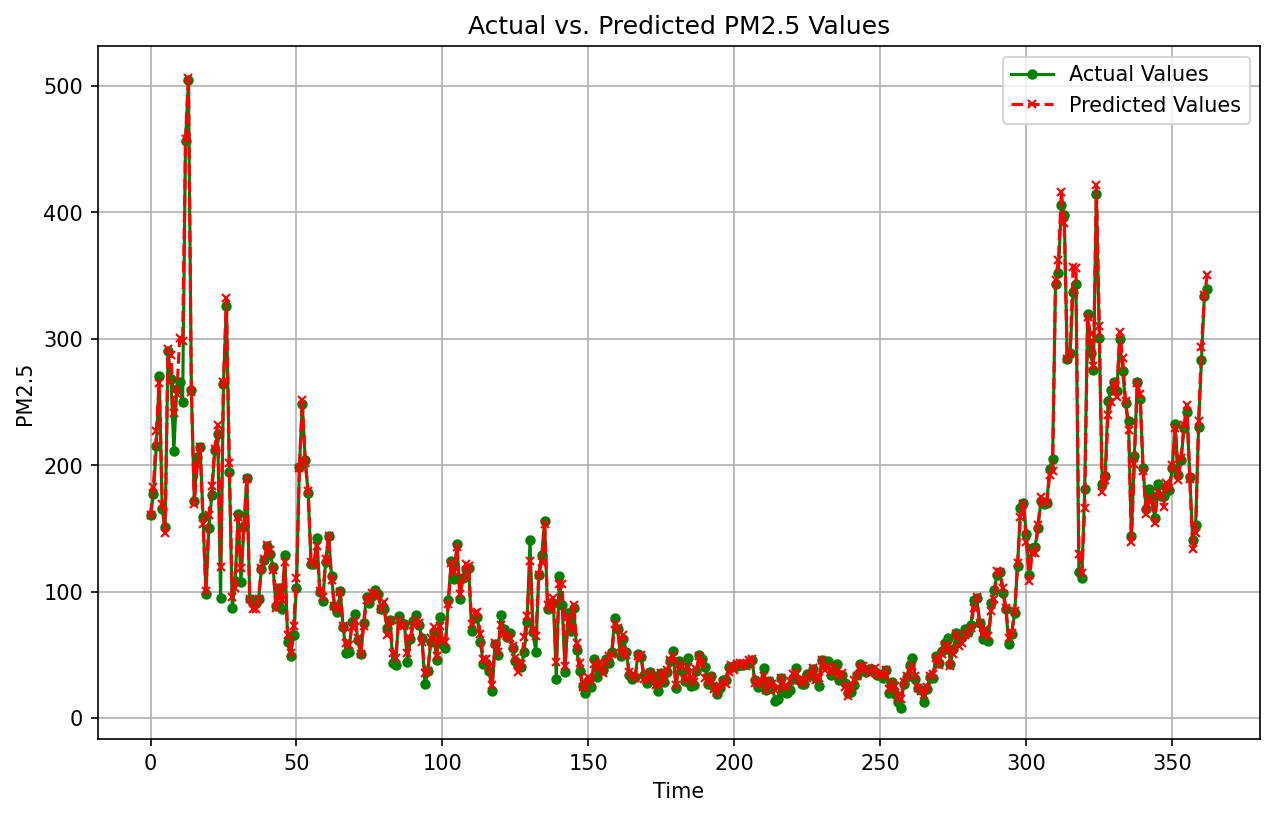

In [41]:
import matplotlib.pyplot as plt

# Define a high resolution for the plot
plt.figure(figsize=(10, 6), dpi=150)

# Plot actual values
plt.plot(y_test, label='Actual Values', color='green', linestyle='-', marker='o', markersize=4)

# Plot predicted values
plt.plot(test_predictions, label='Predicted Values', color='red', linestyle='--', marker='x', markersize=4)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.title('Actual vs. Predicted PM2.5 Values')
plt.legend()
plt.grid(True)

# Save the plot as a high-resolution image file
plt.savefig('actual_vs_predicted_high_res.png', dpi=150)

# Show the plot
plt.show()



In [21]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE, MSE, RMSE, R-squared
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_indices = y_true != 0
    return np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100

train_mape = mean_absolute_percentage_error(y_train, train_predictions)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)

# Print metrics
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R-squared: {train_r2}")
print(f"Test R-squared: {test_r2}")
print(f"Train MAPE: {train_mape}%")
print(f"Test MAPE: {test_mape}%")


Train MAE: 4.527305992816771
Test MAE: 4.717089045496318
Train MSE: 39.700601807047754
Test MSE: 42.51757018749464
Train RMSE: 6.300841357076669
Test RMSE: 6.520549837820016
Train R-squared: 0.9944971365458286
Test R-squared: 0.9946078236797117
Train MAPE: 6.823630371393249%
Test MAPE: 7.000225008093938%
